In [23]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from src.dataset import SpeechDataset
from src.cnn_baseline import CNNEmotion
from src.cnn_lstm import CNNLSTM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [24]:
dataset_mel = SpeechDataset("../data/processed/melspec", feature_type="melspec")
dataset_mfcc = SpeechDataset("../data/processed/mfcc", feature_type="mfcc")


print("MelSpec samples:", len(dataset_mel))
print("MFCC samples:", len(dataset_mfcc))

MelSpec samples: 44652
MFCC samples: 44652


In [25]:
def collate_mfcc(batch):
    features = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    lengths = torch.tensor([f.shape[0] for f in features], dtype=torch.long)
    max_len = lengths.max().item()
    padded = []
    for f in features:
        pad = max_len - f.shape[0]
        f_padded = F.pad(f, (0, 0, 0, pad))
        padded.append(f_padded)
    padded = torch.stack(padded)
    return padded.float(), labels, lengths

def split_dataset(dataset):
    n = len(dataset)
    train_size = int(0.7 * n)
    val_size = int(0.15 * n)
    test_size = n - train_size - val_size
    return random_split(dataset, [train_size, val_size, test_size])

train_mel, val_mel, test_mel = split_dataset(dataset_mel)
train_mfcc, val_mfcc, test_mfcc = split_dataset(dataset_mfcc)

In [26]:
batch_size = 16

test_loader_mel = DataLoader(test_mel, batch_size=batch_size, shuffle=False)
test_loader_mfcc = DataLoader(test_mfcc, batch_size=batch_size, shuffle=False, collate_fn=collate_mfcc)

cnn_mel = CNNEmotion().to(device)
cnn_mel.load_state_dict(torch.load("../notebooks/models/cnn_baseline.pth", map_location=device))
cnn_mel.eval()

cnn_lstm = CNNLSTM().to(device)
cnn_lstm.load_state_dict(torch.load("../notebooks/models/cnn_lstm.pth", map_location=device))
cnn_lstm.eval()

/tmp/ipykernel_45842/2967399589.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_mel.load_state_dict(torch.load("../notebooks/models/cnn_baseline.pth", map_location=d

CNNLSTM(
  (conv): Sequential(
    (0): Conv1d(40, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

In [27]:
def evaluate(model, loader, use_lengths=False):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            if use_lengths:
                x, y, lengths = batch
                x, y, lengths = x.to(device), y.to(device), lengths.to(device)
                out = model(x, lengths)
            else:
                x, y = batch
                x, y = x.to(device), y.to(device)
                out = model(x)
            preds.extend(out.argmax(1).cpu().tolist())
            labels.extend(y.cpu().tolist())
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    cm = confusion_matrix(labels, preds)
    return acc, f1, cm

CNN MelSpectrogram Results :
Accuracy : 0.9701447977310046
F1-score : 0.9701200299918792


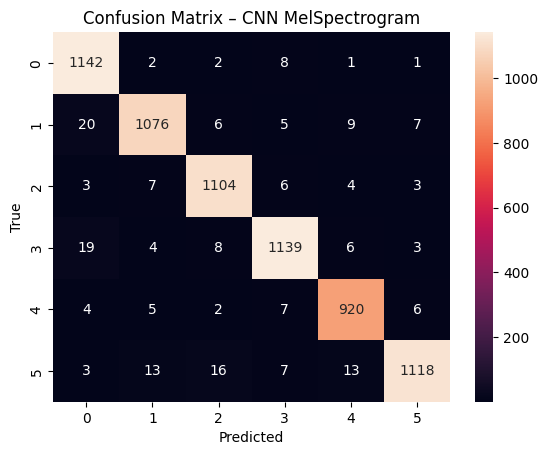

In [28]:
acc_mel, f1_mel, cm_mel = evaluate(cnn_mel, test_loader_mel, use_lengths=False)
print("CNN MelSpectrogram Results :")
print("Accuracy :", acc_mel)
print("F1-score :", f1_mel)

sns.heatmap(cm_mel, annot=True, fmt="d")
plt.title("Confusion Matrix – CNN MelSpectrogram")
plt.xlabel("Predicted")
plt.ylabel("True")
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/confusion_melspec.png", dpi=300, bbox_inches="tight")
plt.show()

CNN+LSTM MFCC Results :
Accuracy : 0.8466935363487088
F1-score : 0.8467986192585281


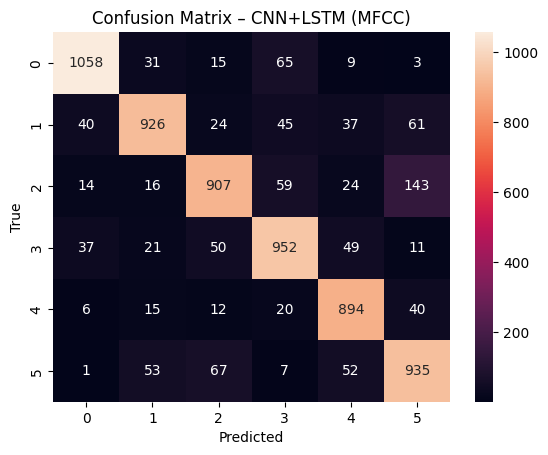

In [29]:
acc_mfcc, f1_mfcc, cm_mfcc = evaluate(cnn_lstm, test_loader_mfcc, use_lengths=True)
print("CNN+LSTM MFCC Results :")
print("Accuracy :", acc_mfcc)
print("F1-score :", f1_mfcc)

sns.heatmap(cm_mfcc, annot=True, fmt="d")
plt.title("Confusion Matrix – CNN+LSTM (MFCC)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("figures/confusion_mfcc.png", dpi=300, bbox_inches="tight")
plt.show()

The 2D CNN is trained on Mel-spectrograms because they are time–frequency images well suited for convolutional filters.

The CNN+LSTM model is trained on MFCCs because they form a temporal sequence, which is appropriate for recurrent architectures.

However, MFCCs are a compressed representation of speech and lose important emotional information, which explains their lower performance.